In [39]:
from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np
import random
import math
import scipy
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

random.seed()

In [31]:
PAULIS = {
    "I" : np.eye(2, dtype = complex),
    "X" : np.array([[0, 1], [1, 0]], dtype = complex),
    "Y" : np.array([[0, -1j], [1j, 0]], dtype = complex),
    "Z" : np.array([[1, 0], [0, -1]], dtype = complex)
}

In [32]:
def pauli_decomposition(H):

    n = int(math.log2(len(H)))
    dims = 2 ** n

    components = defaultdict(int)

    keys = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]

    for i, val in enumerate(product(PAULIS.values(), repeat = n)):

        basis_mat = reduce(np.kron, val)

        coeff = np.dot(H.reshape(-1), basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()

        if not np.allclose(coeff, 0):
            components[keys[i]] = coeff
            
    return components
      
def ansatz(qc, qr, thetas, rounds = 3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r * len(qr) * 2 + i * 2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset + 1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i - 1], qr[i])
    return qc

def matrix_decomposition_circuits(H, add_ansatz):
    
    n = int(np.log2(len(H)))
    dims = 2 ** n
    
    if H.shape != (dims, dims):
        raise ValueError("The imput must be a 2^n x 2^n dimensional matrix.")
        
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, 'qr')
        cr = ClassicalRegister(1, 'cr')
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)
        
        if all(x[1] == "I" for x in paulis):
            circuits[paulistring] = (qc, weight)
            continue
            
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx + 1] = (paulis[idx + 1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
                
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits

def run_circuit(circuit, backend, shots = 10000):
    result = execute(circuit, backend, shots = shots).result()

    counts = result.get_counts()

    return (
        (counts['0'] if '0' in counts.keys() else 0) - (counts['1'] if '1' in counts.keys() else 0)
    )/shots

def expectation(H, rounds, thetas):
    backend = Aer.get_backend('statevector_simulator')
    circuits = matrix_decomposition_circuits(
        H,
        lambda qc, qr: ansatz(qc, qr, thetas, rounds)
    )
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend) * circuits[key][1], circuits.keys()))

In [33]:
# Create an optimizer, SPSA
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, loss_function):
        
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function
        
        self.t = 0
        
    def step(self, current_estimate):
        
        a_t = self.a / (self.t + 1 + self.A) ** self.alpha
        c_t = self.c / (self.t + 1) ** self.gamma
        
        delta = np.random.randint(0, 2, np.array(current_estimate).shape) * 2 - 1
        
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        current_estimate = current_estimate - a_t * g_t
        
        self.t += 1
        
        return current_estimate

In [34]:
# Variational Quantum Eigensolver
def vqe(H, rounds, max_iter, thetas = None, save_steps = None):
    
    cnt_qubits = int(np.log2(len(H)))
    
    if thetas is None:
        thetas = list(map(
            lambda x: random.random(),
            [0] * ((1 + rounds) * cnt_qubits * 2)
        ))
        
    optimizer = SPSA(
        a = 0.9,
        c = 1.0,
        A = max_iter / 10,
        alpha = 0.6,
        gamma = 0.1,
        loss_function = lambda t_thetas: expectation(H, rounds, t_thetas)
    )
    
    for i in range(max_iter):

        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield(i, thetas, expectation(H, rounds, thetas))
    
    return (thetas, expectation(H, rounds, thetas))

In [35]:
H = np.array([[3, 1], [1, 2]], dtype = complex)

result = None
step_size = 3

for step in vqe(H, rounds = 3, max_iter = 100, save_steps = step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step = step[0], ev = step[2]))
    result = step
    
print('The solution is: [\n'
     + "".join(["\t" + str(round(t, 3))
    + ",\n" if i % 3 == 2 else "\t" + str(round(t, 3))
    + ",\t" for i, t in enumerate(result[1])]) + "]")
                
print('The lowest expectation value is: {ev: .3f}'.format(ev = result[2]))            

Step 0. Current expectation value:  2.915
Step 3. Current expectation value:  2.349
Step 6. Current expectation value:  2.356
Step 9. Current expectation value:  1.686
Step 12. Current expectation value:  1.457
Step 15. Current expectation value:  1.483
Step 18. Current expectation value:  1.539
Step 21. Current expectation value:  1.396
Step 24. Current expectation value:  1.432
Step 27. Current expectation value:  1.432
Step 30. Current expectation value:  1.411
Step 33. Current expectation value:  1.411
Step 36. Current expectation value:  1.425
Step 39. Current expectation value:  1.421
Step 42. Current expectation value:  1.430
Step 45. Current expectation value:  1.389
Step 48. Current expectation value:  1.408
Step 51. Current expectation value:  1.404
Step 54. Current expectation value:  1.403
Step 57. Current expectation value:  1.395
Step 60. Current expectation value:  1.392
Step 63. Current expectation value:  1.390
Step 66. Current expectation value:  1.394
Step 69. Curren

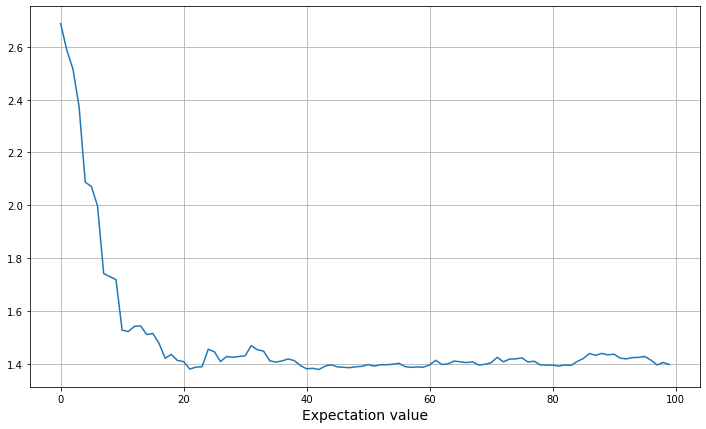

In [40]:
steps = []
evs = []

for step in vqe(H, rounds = 3, max_iter = 100, save_steps = 1):
    steps = steps + [step[2]]
    evs = evs + [step[0]]
    
plt.figure(figsize = (12, 7))
plt.plot(evs, steps)

plt.xlabel("Number of executions", fontsize = 14)
plt.xlabel("Expectation value", fontsize = 14)
plt.grid()

plt.show()

In [41]:
eigenvalues, eigenvectors = scipy.linalg.eig(H)

print("Eigenvalues: ", eigenvalues)

Eigenvalues:  [3.61803399+0.j 1.38196601+0.j]
